In [2]:
from statistics import linear_regression

# Find differences between files pipeline
from pipeline_clean import CleanPipeline
cpp = CleanPipeline()
cpp.process()
# cpp.maping

2024-12-10 04:07:03.781634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733796423.800191  285078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733796423.805326  285078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 04:07:03.825091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from pipeline_data import DataPipeline
from abstracts import ModelContext
from constants import MODEL_CLASSES

ppl = DataPipeline()
ppl.load()

ctx = ModelContext(classes=MODEL_CLASSES, train_data=ppl.train_data, val_data=ppl.val_data)
ctx.restore()

I0000 00:00:1733796432.182927  285078 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4197 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:06:00.0, compute capability: 7.5
/home/cpu/git/university/nvidia-tensorflow-test/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


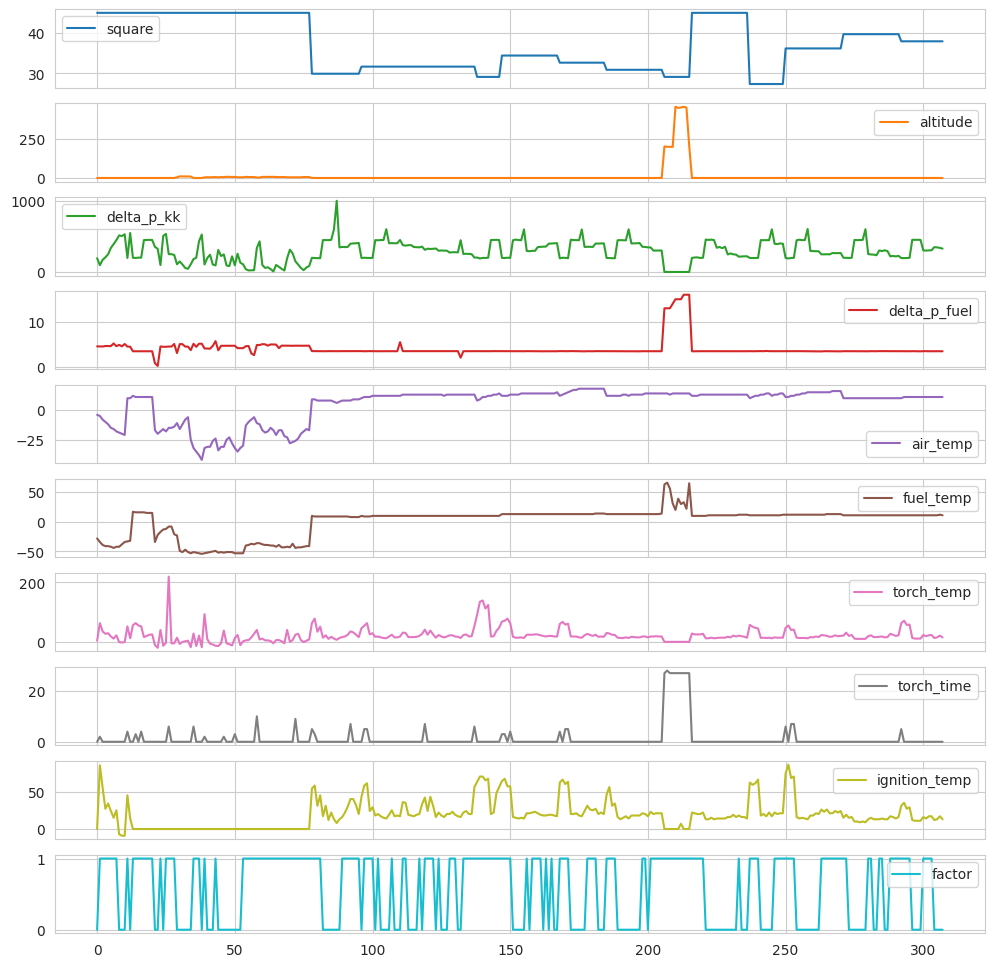

In [4]:
from matplotlib import pyplot
import pandas
data_frame = pandas.DataFrame(ppl.raw_data)
plot_data_frame = data_frame[data_frame.columns]
_ = plot_data_frame.plot(subplots=True, figsize=(12, 12), legend=True)
pyplot.savefig('dataset.png')

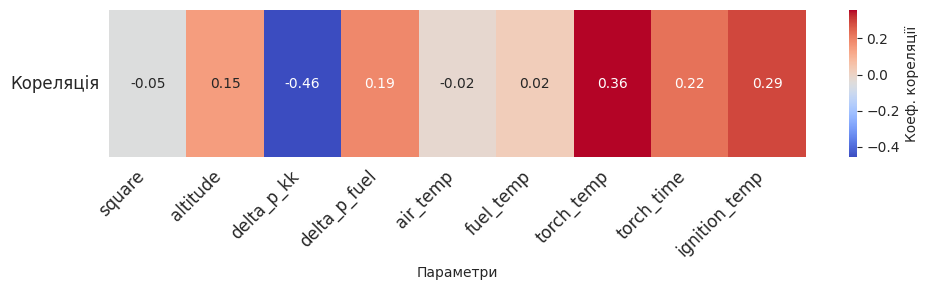

In [5]:
import seaborn
correlation_with_factor = data_frame.corr()['factor'].drop('factor')
correlation_df = correlation_with_factor.to_frame(name='Кореляція').reset_index()
correlation_df.rename(columns={'index': 'Параметри'}, inplace=True)
pyplot.figure(figsize=(10, 3))  
ax = seaborn.heatmap(correlation_df.set_index('Параметри').T, annot=True,
                     cmap='coolwarm', fmt=".2f", cbar=True)
cbar = ax.collections[0].colorbar
cbar.set_label('Коеф. кореляції', rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
pyplot.tight_layout()
pyplot.savefig('corelation-heat-map.png')

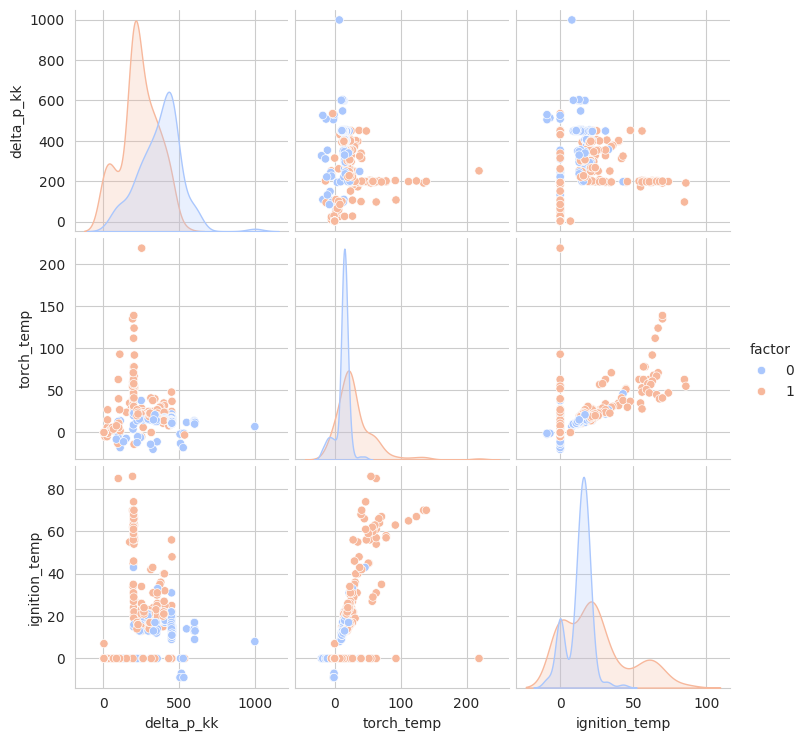

In [6]:
data_frame['factor'] = data_frame['factor'].astype('category')
seaborn.pairplot(data_frame, vars=['delta_p_kk', 'torch_temp', 'ignition_temp'], hue='factor', diag_kind='kde', palette='coolwarm')
pyplot.savefig('pair-plot.png')

In [11]:
features = ppl.raw_data[0].keys()
linear_regression = ctx.strategies[0].model
print (linear_regression)
intercept = linear_regression.intercept_[0]  # Интерсепт
coefficients = linear_regression.coef_[0]
print("Полиномиальная модель:")
print(f"z = {intercept:.2f} " + " + ".join([f"{coeff:.2f}*{feature}" for coeff, feature in zip(coefficients, features)]))


[<logistic_regression.LogisticRegression object at 0x7f06e30b8410>, <gaussian_classifier.GaussianNB object at 0x7f06e31906b0>, <knn_classifier.KNeighborsClassifier object at 0x7f07293efd40>, <svm_classifier.SVMClassifier object at 0x7f06e3412690>, <random_forest.RandomForestClassifier object at 0x7f06e35659d0>, <decision_tree.DecisionTreeClassifier object at 0x7f06e30bb890>, <mlp.MLPClassifier object at 0x7f06e33da930>, <cnn.CNNClassifier object at 0x7f06e32748f0>]
LogisticRegression(C=0.01, l1_ratio=0.01, penalty='l1', random_state=42,
                   solver='liblinear')
Полиномиальная модель:
z = 0.00 0.01*square + 0.01*altitude + -0.01*delta_p_kk + 0.00*delta_p_fuel + 0.00*air_temp + -0.01*fuel_temp + 0.08*torch_temp + 0.00*torch_time + 0.01*ignition_temp


In [68]:
gaussian_naive = ctx.strategies[1].model
priors = gaussian_naive.class_prior_
theta = gaussian_naive.theta_
print (f'Априорные вероятности классов: {priors[0]:.2f} - горить, {priors[1]:.2f} - не горить')
print ('Средние значения признаков для класса - горить')
for coeff, feature in zip(gaussian_naive.theta_[0], features):
     print (f'{feature}: {coeff:.2f}')
print ('Средние значения признаков для класса - не горить')
for coeff, feature in zip(gaussian_naive.theta_[1], features):
     print (f'{feature}: {coeff:.2f}')


Априорные вероятности классов: 0.43 - горить, 0.57 - не горить
Средние значения признаков для класса - горить
square: 37.22
altitude: 0.95
delta_p_kk: 372.23
delta_p_fuel: 3.60
air_temp: 5.91
fuel_temp: 0.50
torch_temp: 12.11
torch_time: 0.02
ignition_temp: 13.32
Средние значения признаков для класса - не горить
square: 36.60
altitude: 19.61
delta_p_kk: 234.60
delta_p_fuel: 4.41
air_temp: 4.85
fuel_temp: 0.63
torch_temp: 30.53
torch_time: 2.37
ignition_temp: 24.07


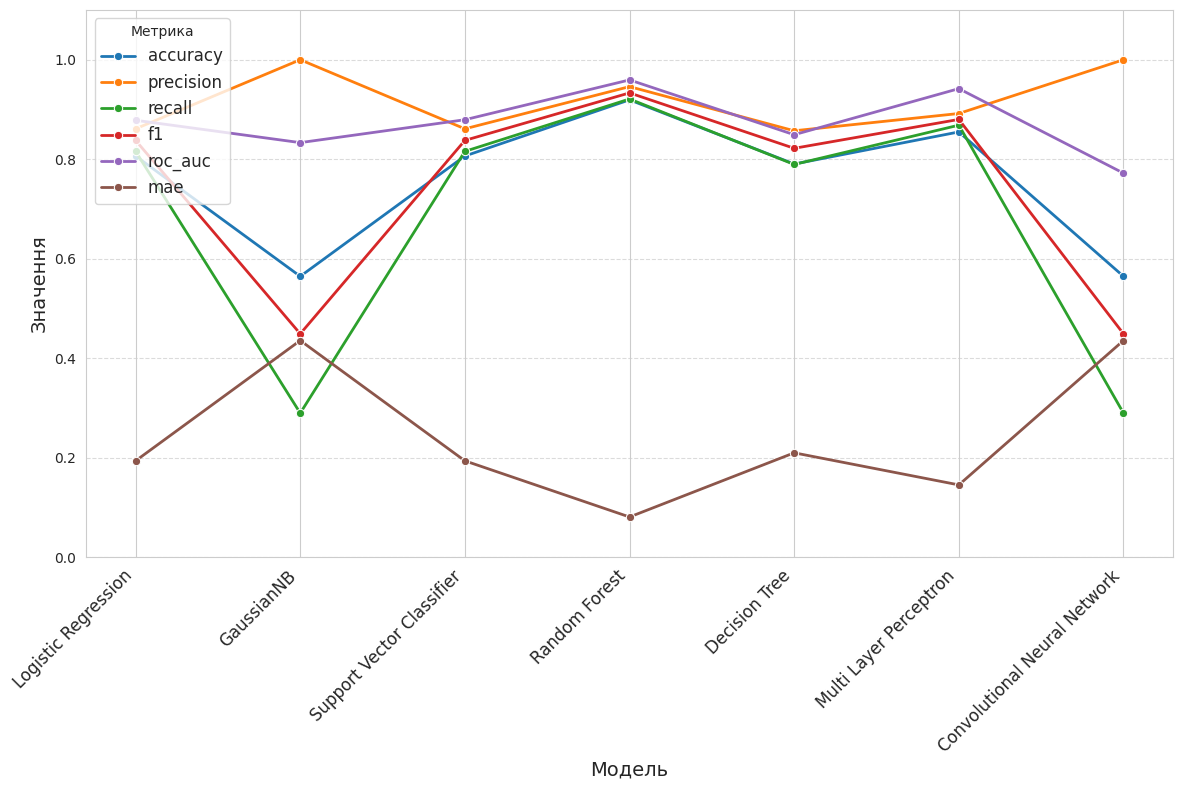

In [35]:
result = dict()
for strategy in ctx.strategies:
    x = strategy.metrics
    row = {
        'accuracy': x['accuracy'],
        'precision': x['precision'],
        'recall': x['recall'],
        'f1': x['f1'],
        'roc_auc': x['roc_auc'],
        'mae': x['mae'],
    }
    if not x['overfit']:
        result[strategy.model_name] = (row)

import seaborn
import matplotlib.pyplot
import pandas
data_frame =pandas.DataFrame(result).T
df_melted = data_frame.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_melted.rename(columns={'index': 'Model'}, inplace=True)

pyplot.figure(figsize=(12, 8))
seaborn.lineplot(data=df_melted, x='Model', y='Value', hue='Metric', marker='o', linewidth=2)

pyplot.ylabel('Значення', fontsize=14)
pyplot.xlabel('Модель', fontsize=14)
pyplot.xticks(rotation=45, ha='right', fontsize=12)
pyplot.ylim(0, 1.1)
pyplot.grid(axis='y', linestyle='--', alpha=0.7)
pyplot.legend(title='Метрика', fontsize=12, loc='upper left')
pyplot.tight_layout()
pyplot.savefig('mtrics-plot.png')